# Cell type annotation from marker genes

In single-cell, we have no prior information of which cell type each cell belongs.
To assign cell type labels, we first project all cells in a shared embedded space, 
then we find communities of cells that show a similar transcription profile and finally
we check what cell type specific markers are expressed. If more than one marker
gene is available, statistical methods can be used to test if a set of markers is
enriched in a given cell population.

In this notebook we showcase how to use `decoupler` for cell type annotation with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

シングルセルでは、各細胞がどの細胞タイプに属するかについての事前情報はない。細胞型のラベルを付けるには、まず全細胞を共通の埋め込み空間に投影し、次に類似の転写プロファイルを示す細胞のコミュニティを見つけ、最後にどのような細胞型特異的マーカーが発現しているかを調べる。つ以上のマーカー遺伝子が利用可能であれば、統計的手法を使って、あるマーカーセットが与えられた細胞集団で濃縮されているかどうかを調べることができる。

このノートブックでは、3k PBMC 10Xデータセットを使って、細胞タイプのアノテーションにdecouplerを使う方法を紹介します。このデータは、健康なドナーの3k PBMCから構成されており、10x Genomics社からこのウェブページから自由に入手できます。

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

まず、関連するパッケージ、scRNA-seqデータを扱うscanpyと統計的手法を使うdecouplerをロードする必要がある。

In [1]:
import numpy as np

In [2]:
import scanpy as sc

In [3]:
# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [4]:
import decoupler as dc

In [30]:
import warnings

warnings.simplefilter('ignore', FutureWarning)

## Single-cell processing

### Loading the data-set

We can download the data easily using `scanpy`:

In [5]:
adata = sc.datasets.pbmc3k()

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [11]:
adata.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
adata.obs.head()

""
index
AAACATACAACCAC-1
AAACATTGAGCTAC-1
AAACATTGATCAGC-1
AAACCGTGCTTCCG-1
AAACCGTGTATGCG-1


In [13]:
adata.var.head()

,gene_ids
index,
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945


### QC, projection and clustering


Here we follow the standard pre-processing steps as described in the [scanpy vignette](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).
These steps carry out the selection and filtration of cells based on 
quality control metrics and the data normalization.

ここでは、scanpy vignetteで説明されている標準的な前処理ステップに従う。これらのステップでは、品質管理指標に基づいた細胞の選択と濾過、データの正規化を行う。

In [14]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [15]:
# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')

In [16]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt'], percent_top=None,
    log1p=False, inplace=True
)

In [17]:
# Filter cells following standard QC criteria.
adata = adata[adata.obs.n_genes_by_counts < 2500, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [18]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

In [19]:
sc.pp.log1p(adata)

In [20]:
adata.layers['log_norm'] = adata.X.copy()

Then we group cells based on the similarity of their transcription profiles. 
To visualize the communities we perform UMAP reduction.

次に、転写プロファイルの類似性に基づいて細胞をグループ化する。コミュニティを可視化するために、UMAPリダクションを行う。

In [21]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [22]:
# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [23]:
sc.pp.scale(adata, max_value=10)

In [24]:
# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

In [25]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'log_norm'

In [26]:
# Restore X to be norm counts
dc.swap_layer(
    adata,
    layer_key='log_norm',  # from log_norm to X
    X_layer_key=None,  # from X to None
    inplace=True
)

In [27]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'log_norm'

In [28]:
# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [29]:
# Generate UMAP features
sc.tl.umap(adata)

In [31]:
# Run leiden clustering algorithm
sc.tl.leiden(adata)

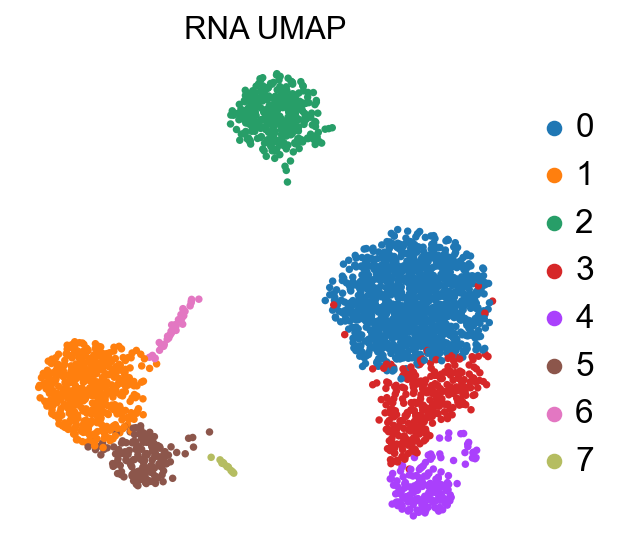

In [32]:
# Visualize
sc.pl.umap(
    adata, color='leiden', title='RNA UMAP',
    frameon=False, legend_fontweight='normal', legend_fontsize=15
)

At this stage, we have identified communities of cells that show a similar 
transcriptomic profile, and we would like to know to which cell type they 
probably belong.

現段階では、似たようなトランスクリプトーム・プロファイルを示す細胞のコミュニティを同定しており、それらがおそらくどの細胞タイプに属するかを知りたい。

## Marker genes

To annotate single cell clusters, we can use cell type specific marker genes. 
These are genes that are mainly expressed exclusively by a specific cell type, 
making them useful to distinguish heterogeneous groups of cells. Marker genes were
discovered and annotated in previous studies and there are some resources that
collect and curate them.

[Omnipath](https://omnipathdb.org/) is one of the largest available databases of 
curated prior knowledge. Among its resources, there is 
[PanglaoDB](https://panglaodb.se/), a database of cell type markers, 
which can be easily accessed using a wrapper to Omnipath from `decoupler`. 

単一細胞クラスターをアノテーションするには、細胞型特異的マー カー遺伝子を使うことができる。これらの遺伝子は主に特定の細胞タイプによってのみ発現され、異種の細胞群を区別するのに有用である。マーカー遺伝子は過去の研究で発見され、アノテーションされており、それらを収集し、キュレーションしているリソースがいくつかある。

Omnipathは、利用可能な最大級の事前知識データベースである。PanglaoDBは細胞型マーカーのデータベースで、decouplerからOmnipathへのラッパーを使って簡単にアクセスできる。

In [33]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')

In [34]:
markers.head()

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.000000,0.004394,True,0.003311,0.020480,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.000000,0.008420,True,0.000000,0.014915,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.005039,True,0.903226,0.012408,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.000000,0.008233,True,0.225806,0.013758,9606,Epithelium,0.013


Since our data-set is from human cells, and we want best quality of the markers, we can filter by `canonical_marker` and `human`:

今回のデータセットはヒトの細胞から得られたものであり、マーカーの質を最も良くしたいので、canonical_markerとhumanでフィルターをかけることができる：

In [35]:
# Filter by canonical_marker and human
markers = markers[
    markers['human']
    & markers['canonical_marker']
    & (markers['human_sensitivity'] > 0.5)
]

In [36]:
# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]

In [37]:
markers.head()

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
6,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.005031,True,0.314286,0.012826,9606,Pancreas,0.013
14,PRSS3,True,Acinar cells,Endoderm,True,0.833333,0.028931,True,0.028571,0.000000,9606,Pancreas,0.006
15,CELA3A,True,Acinar cells,Endoderm,True,0.833333,0.000000,True,0.128571,0.000000,9606,Pancreas,0.001
17,PRSS1,True,Acinar cells,Endoderm,True,1.000000,0.005975,True,0.028571,0.000000,9606,Pancreas,0.002


For this example we will use these markers, but any collection of genes could be used. To see the list of available resources inside `Omnipath`, run `dc.show_resources()`

この例ではこれらのマーカーを使用するが、遺伝子のコレクションであれば何でも使用できる。Omnipath内で利用可能なリソースのリストを見るには、dc.show_resources() を実行する。

In [38]:
dc.show_resources()

['Adhesome',
 'Almen2009',
 'Baccin2019',
 'CORUM_Funcat',
 'CORUM_GO',
 'CSPA',
 'CSPA_celltype',
 'CancerDrugsDB',
 'CancerGeneCensus',
 'CancerSEA',
 'CellCall',
 'CellCellInteractions',
 'CellChatDB',
 'CellChatDB_complex',
 'CellPhoneDB',
 'CellPhoneDB_complex',
 'CellTalkDB',
 'CellTypist',
 'Cellinker',
 'Cellinker_complex',
 'ComPPI',
 'CytoSig',
 'DGIdb',
 'DisGeNet',
 'EMBRACE',
 'Exocarta',
 'GO_Intercell',
 'GPCRdb',
 'Guide2Pharma',
 'HGNC',
 'HPA_secretome',
 'HPA_subcellular',
 'HPA_tissue',
 'HPMR',
 'HumanCellMap',
 'ICELLNET',
 'ICELLNET_complex',
 'IntOGen',
 'Integrins',
 'InterPro',
 'KEGG-PC',
 'Kirouac2010',
 'LOCATE',
 'LRdb',
 'Lambert2018',
 'MCAM',
 'MSigDB',
 'Matrisome',
 'MatrixDB',
 'Membranome',
 'NetPath',
 'OPM',
 'PROGENy',
 'PanglaoDB',
 'Phobius',
 'Phosphatome',
 'Ramilowski2015',
 'Ramilowski_location',
 'SIGNOR',
 'SignaLink_function',
 'SignaLink_pathway',
 'Surfaceome',
 'TCDB',
 'TFcensus',
 'TopDB',
 'UniProt_family',
 'UniProt_keyword',
 'Un

## Enrichment with Over Representation Analysis (ORA)

To infer functional enrichment scores we will run the Over Representation Analysis (`ora`) method.
As input data it accepts an expression matrix (`decoupler.run_ora`) or the results of differential expression analysis (`decoupler.get_ora_df`).
For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S*), and for the latter a user-defined
significance filtering can be used.
Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (`net`).
Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets.
The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.
     
We can run `ora` with a simple one-liner:

機能エンリッチメントスコアを推測するために、Over Representation Analysis (ora)メソッドを実行する。入力データとして、発現行列(decoupler.run_ora)または差分発現解析結果(decoupler.get_ora_df)を受け取る。前者では、デフォルトでサンプルごとの発現遺伝子の上位5％が注目セット（S*）として選択され、後者ではユーザー定義の有意性フィルタリングを使用できる。S*が得られたら、使用する遺伝子セットリソース（net）に格納されている各セットについて、セット操作を使用して分割表を作成する。分割表を用いて、oraはセット間の重複の有意性を検定するために片側フィッシャー正確検定を実行する。最終的なスコアは得られたp値を対数変換することで得られ、値が大きいほど有意であることを意味する。

oraは簡単なワンライナーで実行できる：

In [39]:
?dc.run_ora

Signature:
dc.run_ora(
    mat,
    net,
    source='source',
    target='target',
    n_up=None,
    n_bottom=0,
    n_background=20000,
    min_n=5,
    seed=42,
    verbose=False,
    use_raw=True,
)
Docstring:
Over Representation Analysis (ORA).

ORA measures the overlap between the target feature set and a list of most altered molecular features in `mat`.
The most altered molecular features can be selected from the top and or bottom of the molecular readout distribution, by
default it is the top 5% positive values. With these, a contingency table is build and a one-tailed Fisher’s exact test is
computed to determine if a regulator’s set of features are over-represented in the selected features from the data.
The resulting score, `ora_estimate`, is the minus log10 of the obtained p-value.

Parameters
----------
mat : list, DataFrame or AnnData
    List of [features, matrix], dataframe (samples x features) or an AnnData
    instance.
net : DataFrame
    Network in long format.
sourc

In [40]:
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

1 features of mat are empty, they will be removed.
Running ora on mat with 2638 samples and 13713 targets for 36 sources.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2638/2638 [00:03<00:00, 660.47it/s]


In [41]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'
    varm: 'PCs'
    layers: 'log_norm'
    obsp: 'distances', 'connectivities'

The obtained scores (-log10(p-value))(`ora_estimate`) and p-values (`ora_pvals`) are stored in the `.obsm` key:

In [42]:
adata.obsm['ora_estimate'].head()

source,Acinar cells,Adipocytes,Alpha cells,B cells,B cells naive,Dendritic cells,Ductal cells,Endothelial cells,Enterocytes,Ependymal cells,...,Pancreatic stellate cells,Pericytes,Plasma cells,Plasmacytoid dendritic cells,Platelets,Podocytes,Proximal tubule cells,Pulmonary alveolar type II cells,Smooth muscle cells,T cells
AAACATACAACCAC-1,-0.000000,0.530653,0.885021,4.065376,2.641014,5.720316,-0.000000,-0.000000,-0.000000,-0.0,...,-0.0,0.885021,2.538999,0.437907,1.871866,-0.000000,-0.000000,-0.0,-0.0,11.728494
AAACATTGAGCTAC-1,-0.000000,-0.000000,0.885021,5.618952,13.894150,13.010816,2.171878,0.827013,0.795482,-0.0,...,-0.0,0.885021,2.538999,0.437907,2.858756,-0.000000,-0.000000,-0.0,-0.0,2.981581
AAACATTGATCAGC-1,-0.000000,0.530653,0.885021,1.542530,6.107693,5.720316,-0.000000,0.298770,-0.000000,-0.0,...,-0.0,0.885021,0.569257,-0.000000,5.213387,-0.000000,0.613213,-0.0,-0.0,9.970169
AAACCGTGCTTCCG-1,0.613213,1.356127,0.885021,2.703919,2.641014,20.564684,0.885021,0.827013,-0.000000,-0.0,...,-0.0,-0.000000,1.443226,0.437907,8.019237,0.613213,-0.000000,-0.0,-0.0,1.957728
AAACCGTGTATGCG-1,-0.000000,-0.000000,0.885021,1.542530,0.349060,9.831072,-0.000000,0.298770,0.795482,-0.0,...,-0.0,-0.000000,0.569257,0.437907,2.858756,-0.000000,0.613213,-0.0,-0.0,1.957728


In [43]:
adata.obsm['ora_pvals'].head()

source,Acinar cells,Adipocytes,Alpha cells,B cells,B cells naive,Dendritic cells,Ductal cells,Endothelial cells,Enterocytes,Ependymal cells,...,Pancreatic stellate cells,Pericytes,Plasma cells,Plasmacytoid dendritic cells,Platelets,Podocytes,Proximal tubule cells,Pulmonary alveolar type II cells,Smooth muscle cells,T cells
AAACATACAACCAC-1,1.000000,0.294678,0.13031,0.000086,2.285523e-03,1.904074e-06,1.000000,1.000000,1.000000,1.0,...,1.0,0.13031,0.002891,0.364832,1.343180e-02,1.000000,1.000000,1.0,1.0,1.868556e-12
AAACATTGAGCTAC-1,1.000000,1.000000,0.13031,0.000002,1.275999e-14,9.754026e-14,0.006732,0.148932,0.160147,1.0,...,1.0,0.13031,0.002891,0.364832,1.384343e-03,1.000000,1.000000,1.0,1.0,1.043322e-03
AAACATTGATCAGC-1,1.000000,0.294678,0.13031,0.028673,7.803824e-07,1.904074e-06,1.000000,0.502609,1.000000,1.0,...,1.0,0.13031,0.269614,1.000000,6.118047e-06,1.000000,0.243661,1.0,1.0,1.071103e-10
AAACCGTGCTTCCG-1,0.243661,0.044043,0.13031,0.001977,2.285523e-03,2.724681e-21,0.130310,0.148932,1.000000,1.0,...,1.0,1.00000,0.036039,0.364832,9.566722e-09,0.243661,1.000000,1.0,1.0,1.102230e-02
AAACCGTGTATGCG-1,1.000000,1.000000,0.13031,0.028673,4.476517e-01,1.475461e-10,1.000000,0.502609,0.160147,1.0,...,1.0,1.00000,0.269614,0.364832,1.384343e-03,1.000000,0.243661,1.0,1.0,1.102230e-02


## Visualization

To visualize the obtained scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract them from the `adata` object.

得られたスコアを視覚化するために、scanpyのプロット関数の多くを再利用することができます。しかし、最初にadataオブジェクトから得点を抽出する必要があります。

In [44]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

In [45]:
acts

AnnData object with n_obs × n_vars = 2638 × 36
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

In [46]:
# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()

In [47]:
acts_v

array([-0.       ,  0.5306527,  0.8850211, ..., -0.       , -0.       ,
       11.728494 ], dtype=float32)

In [48]:
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])

In [49]:
max_e

25.194302

In [50]:
acts.X[~np.isfinite(acts.X)] = max_e

In [51]:
acts

AnnData object with n_obs × n_vars = 2638 × 36
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example:

dc.get_actsは、取得したアクティビティを.X属性に保持する新しいAnnDataオブジェクトを返すので、例えば、多くのscanpy関数を再利用することができます：

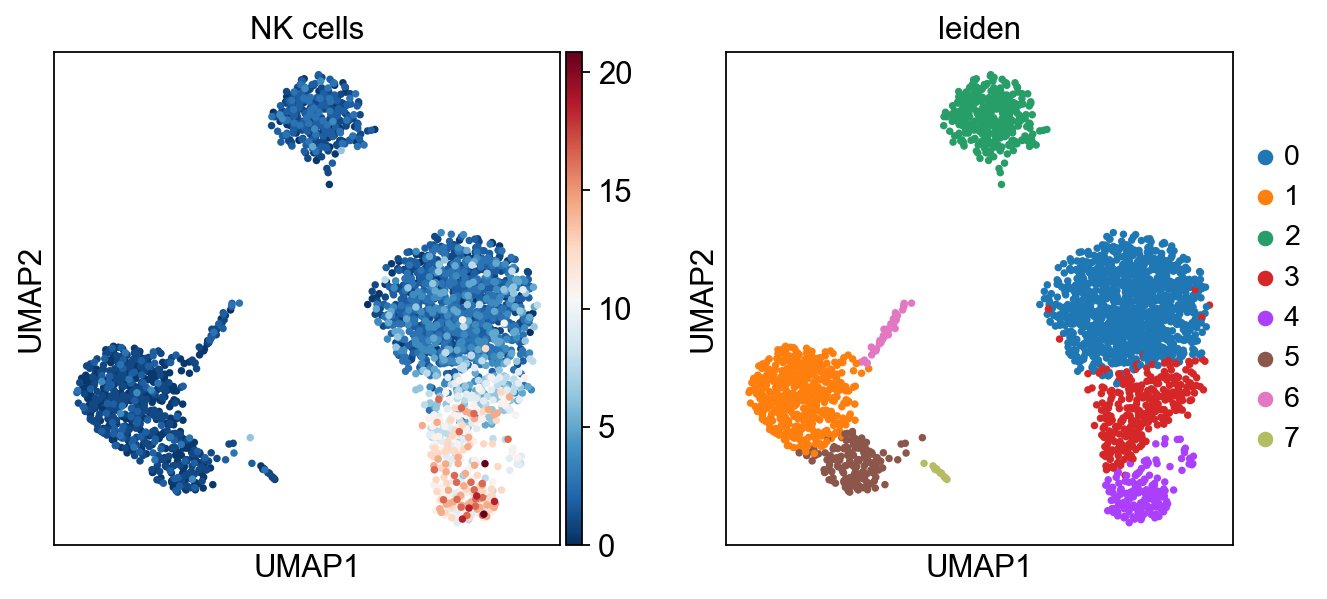

In [52]:
sc.pl.umap(acts, color=['NK cells', 'leiden'], cmap='RdBu_r')

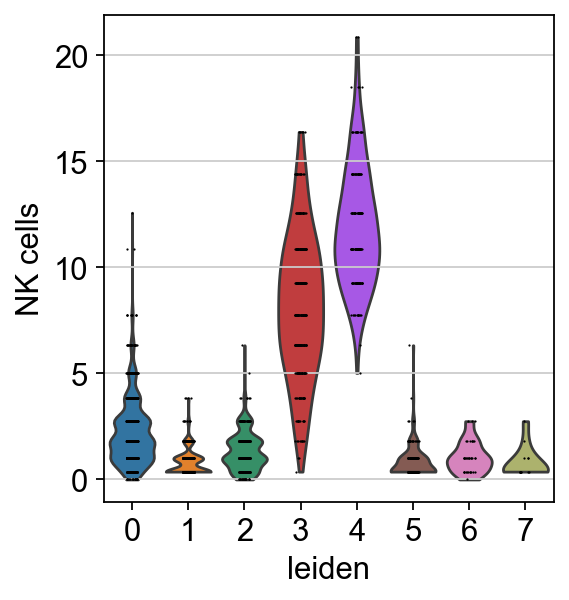

In [53]:
sc.pl.violin(acts, keys=['NK cells'], groupby='leiden')

The cells highlighted seem to be enriched by NK cell marker genes.

強調表示された細胞は、NK細胞マーカー遺伝子によって濃縮されているようだ。

## Annotation

With `decoupler` we can also identify which are the top predicted cell types per cluster using the 
function `dc.rank_sources_groups`. Here, it identifies "marker" cell types per cluster using
same statistical tests available in scanpy's `scanpy.tl.rank_genes_groups`.

dc.rank_sources_groups関数を使えば、クラスターごとに予測される上位の細胞タイプを特定することもできる。ここでは、scanpyのscanpy.tl.rank_genes_groupsで利用できるのと同じ統計的検定を使って、クラスターごとに「マーカー」細胞型を特定する。

In [54]:
?dc.rank_sources_groups

Signature:
dc.rank_sources_groups(
    adata,
    groupby,
    reference='rest',
    method='t-test_overestim_var',
)
Docstring:
Rank sources for characterizing groups.

Parameters
----------
adata : AnnData
    AnnData obtained after running ``decoupler.get_acts``.
groupby: str
    The key of the observations grouping to consider.
reference: str, list
    Reference group or list of reference groups to use as reference.
method: str
    Statistical method to use for computing differences between groups. Avaliable methods
    include: ``{'wilcoxon', 't-test', 't-test_overestim_var'}``.

Returns
-------
results: DataFrame with changes in source activity score between groups.
File:      ~/mambaforge/envs/py_scvi/lib/python3.10/site-packages/decoupler/utils_anndata.py
Type:      function

In [55]:
df = dc.rank_sources_groups(
    acts, groupby='leiden',
    reference='rest', method='t-test_overestim_var'
)

In [56]:
df.head()

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,T cells,43.372538,5.579798,6.171307e-300,2.221671e-298
1,0,rest,Erythroid-like and erythroid precursor cells,8.042804,0.144541,1.400976e-15,2.654481e-15
2,0,rest,Pericytes,7.022572,0.127029,2.862101e-12,4.906458e-12
3,0,rest,Neurons,6.068221,0.097898,1.513801e-09,2.477129e-09
4,0,rest,Oligodendrocytes,5.136233,0.062480,3.056686e-07,4.585029e-07


We can then extract the top 3 predicted cell types per cluster:

そして、クラスターごとに予測された上位3つの細胞タイプを抽出することができる：

In [57]:
n_ctypes = 3

ctypes_dict = (
    df
    .groupby('group')
    .head(n_ctypes)
    .groupby('group')['names']
    .apply(lambda x: list(x))
    .to_dict()
)

In [58]:
ctypes_dict

{'0': ['T cells', 'Erythroid-like and erythroid precursor cells', 'Pericytes'],
 '1': ['Neutrophils', 'Acinar cells', 'Dendritic cells'],
 '2': ['B cells naive', 'B cells', 'Plasma cells'],
 '3': ['NK cells', 'Gamma delta T cells', 'T cells'],
 '4': ['Gamma delta T cells', 'NK cells', 'Hepatic stellate cells'],
 '5': ['Macrophages', 'Dendritic cells', 'Monocytes'],
 '6': ['Dendritic cells', 'Acinar cells', 'Ductal cells'],
 '7': ['Pancreatic stellate cells', 'Platelets', 'Endothelial cells']}

We can visualize the obtained top predicted cell types:

得られた予測上位の細胞タイプを可視化することができる：

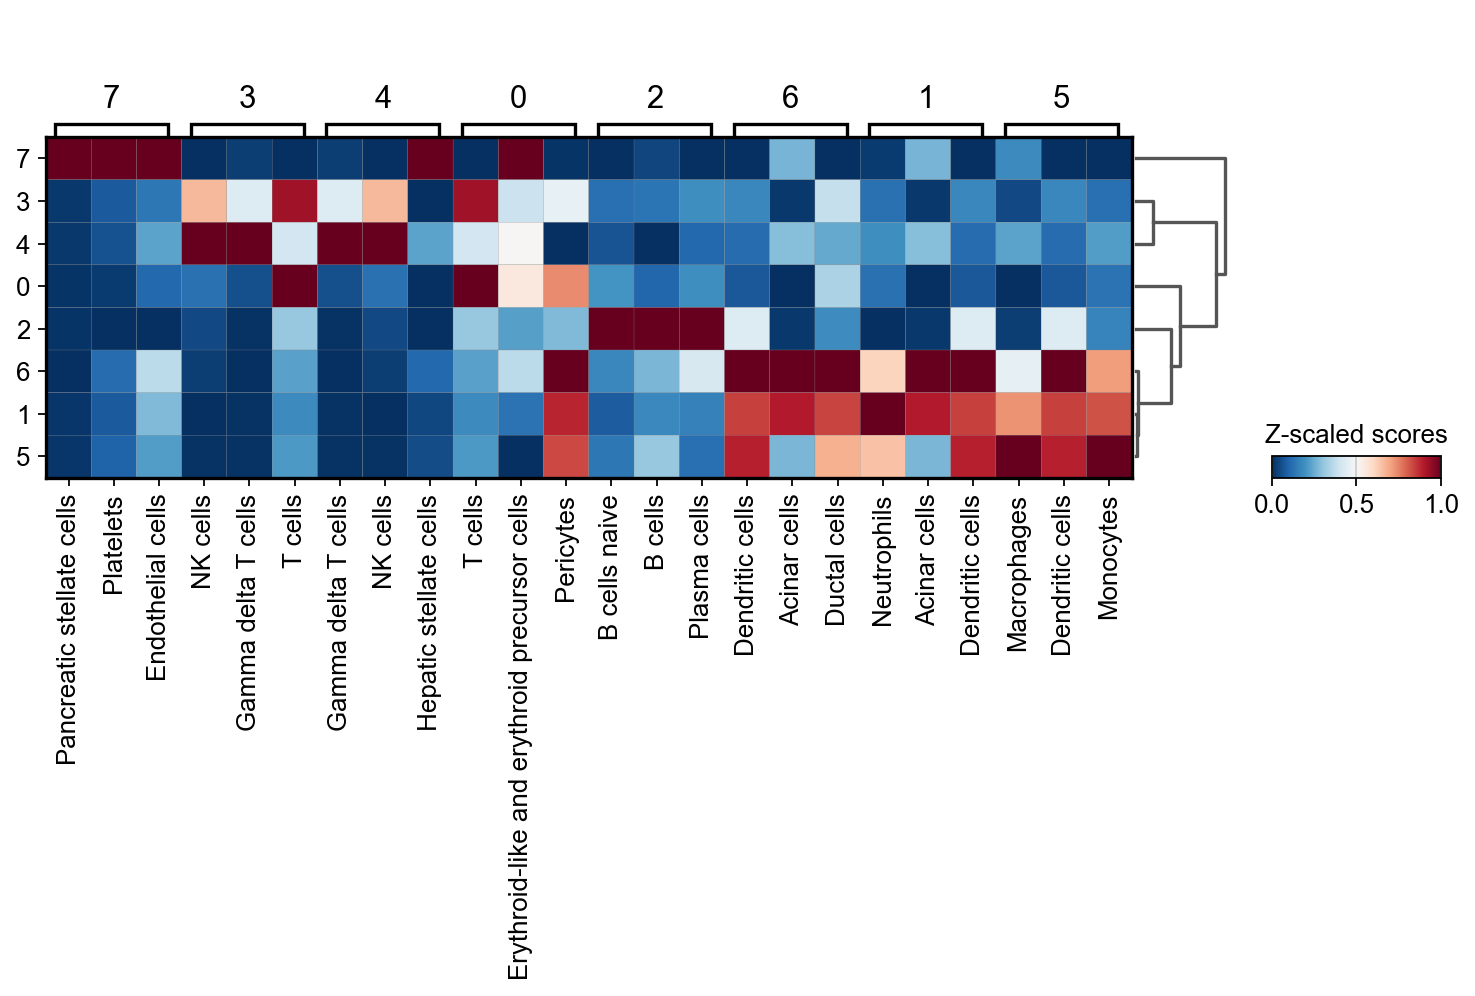

In [59]:
sc.pl.matrixplot(
    acts, ctypes_dict, 'leiden',
    dendrogram=True, standard_scale='var',
    colorbar_title='Z-scaled scores', cmap='RdBu_r'
)

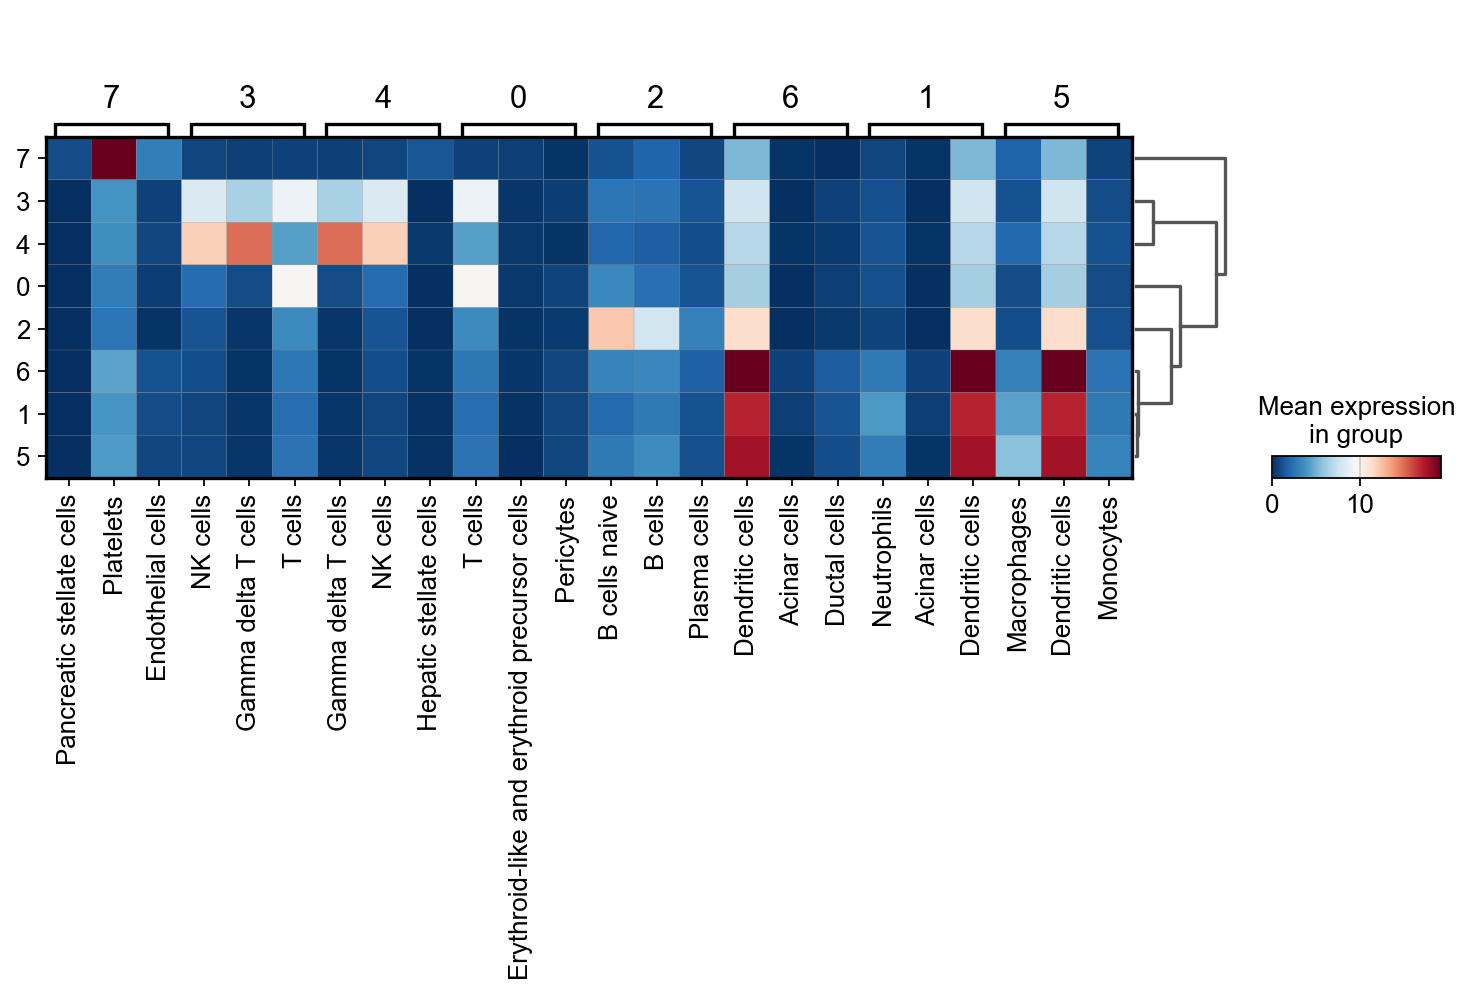

In [60]:
sc.pl.matrixplot(
    acts, ctypes_dict, 'leiden',
    dendrogram=True,  # standard_scale='var',
    # colorbar_title='Z-scaled scores',
    cmap='RdBu_r'
)

From this plot we see that cluster 7 belongs to Platelets, cluster 4 appear to be NK cells, custers 0 and 3 might be T-cells, cluster 2 should be some sort of B cells and that clusters 6,5 and 1 belong to the myeloid lineage.

We can check individual cell types by plotting their distributions:

このプロットから、クラスター7は血小板、クラスター4はNK細胞、クラスター0と3はT細胞、クラスター2はある種のB細胞、そしてクラスター6、5と1は骨髄系に属することがわかる。

分布をプロットすることで、個々の細胞タイプを確認することができる：

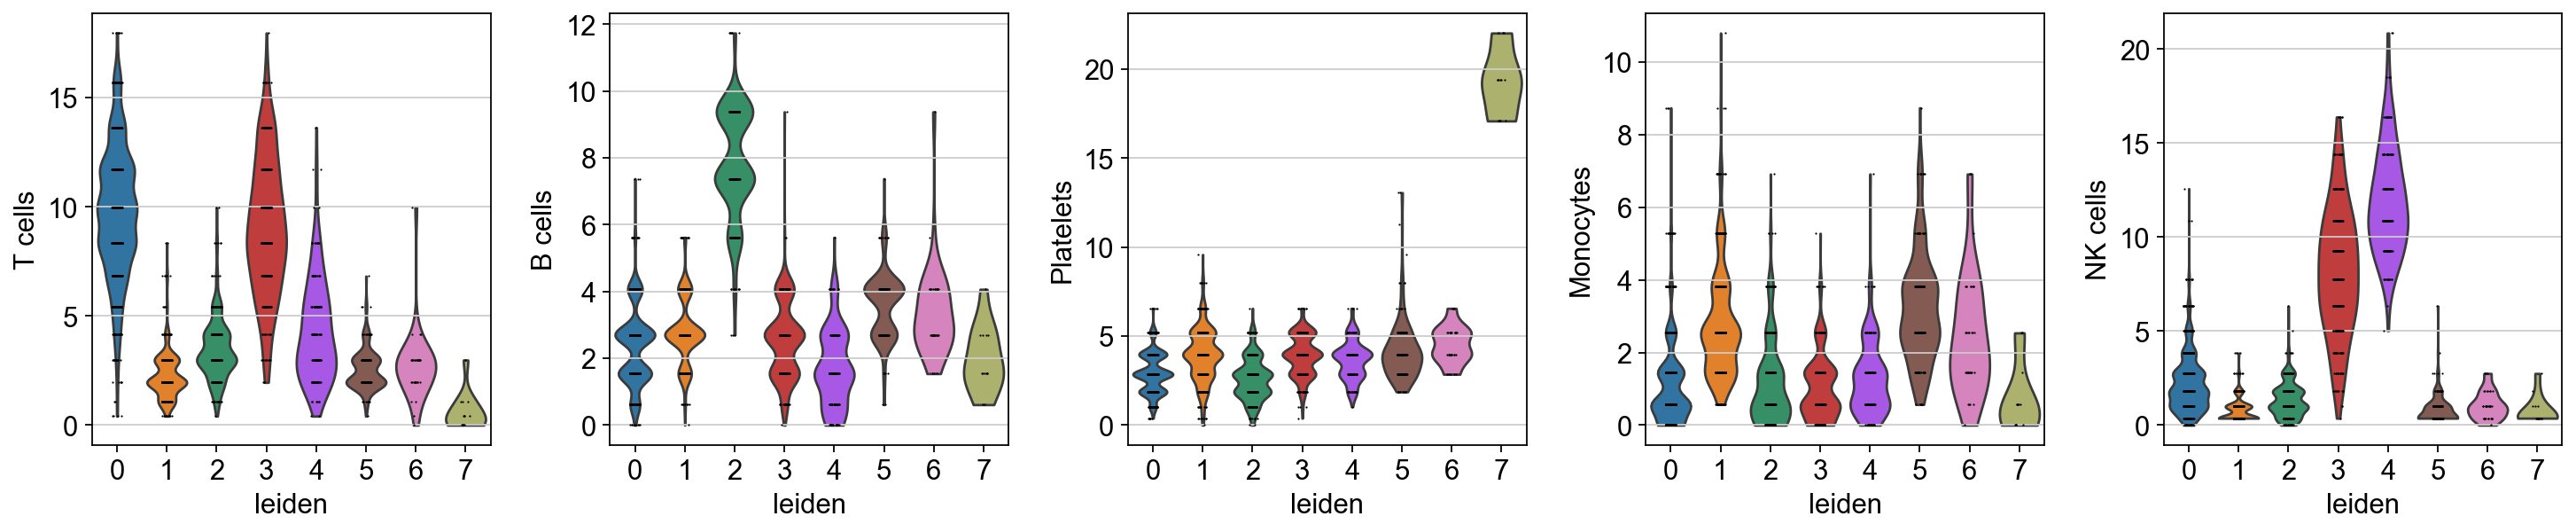

In [61]:
sc.pl.violin(
    acts,
    keys=['T cells', 'B cells', 'Platelets', 'Monocytes', 'NK cells'],
    groupby='leiden'
)

The final annotation should be done manually based on the assessment of the enrichment results. However, an automatic prediction can be made by assigning the top predicted cell type per cluster. This approach does not require expertise in the tissue being studied but **can be prone to errors**. Nonetheless it can be useful to generate a first draft, let's try it:

最終的なアノテーションは、濃縮結果の評価に基づいて手作業で行う。しかし、クラスターごとに予測される上位の細胞タイプを割り当てることで、自動予測を行うこともできる。このアプローチは、研究対象の組織に関する専門知識は必要ないが、エラーを起こしやすい。それにもかかわらず、最初のドラフトを作成するのに有用である：

In [62]:
annotation_dict = (
    df
    .groupby('group')
    .head(1)
    .set_index('group')['names']
    .to_dict()
)

In [63]:
annotation_dict

{'0': 'T cells',
 '1': 'Neutrophils',
 '2': 'B cells naive',
 '3': 'NK cells',
 '4': 'Gamma delta T cells',
 '5': 'Macrophages',
 '6': 'Dendritic cells',
 '7': 'Pancreatic stellate cells'}

Once we have selected the top cell type we can finally annotate:

一番上のセルタイプを選択したら、いよいよ注釈を入れる：

In [64]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

In [66]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'dendrogram_leiden', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'
    varm: 'PCs'
    layers: 'log_norm'
    obsp: 'distances', 'connectivities'

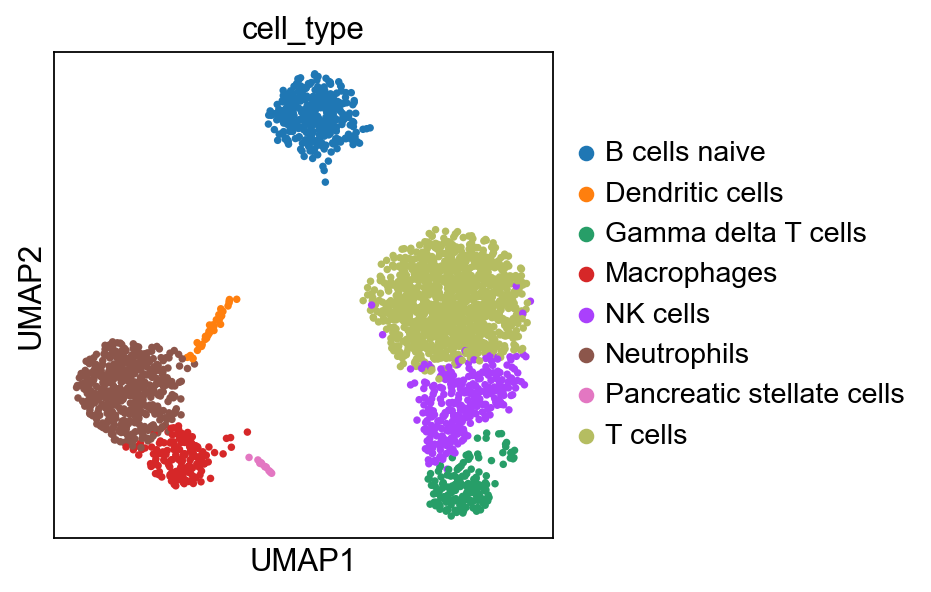

In [67]:
# Visualize
sc.pl.umap(adata, color='cell_type')

Compared to the annotation obtained by the `scanpy` tutorial, it is very similar but there are some errors, highlything the limitation of automatic annotation.

scanpyのチュートリアルによって得られた注釈と比較すると、非常によく似ているが、いくつかの誤りがあり、自動注釈の限界を物語っている。